# Pipeline to evaluate WER on specific names

The fact that the ground-truth is not a verbatim transcription constraints us to not consider the WER as primary source of measure. Instead, we should focus on specific names or properties to search in the text to see if the ASR systems have recognized them.

We build a pipeline that does the following:
1. Load the ground truth srt
2. Extract entities from the ground truth srt
3. Extract the same type of entities from the ASR srt
4. Align entities in the same temporal window
5. Use similarity to set a comparison
6. Compare words in the ASR with respect to the ones into the ground-truth

In [ ]:
from utils.names import get_file_names, get_model_names
import matplotlib.pyplot as plt
import spacy
import json
import pandas as pd

files = get_file_names()
models = get_model_names()

## 1) Entity extraction with Spacy

In [ ]:
def extract_entities(text, nlp):
    """
    Estrae le entità da un testo utilizzando spaCy.
    Restituisce una lista di dizionari nel formato richiesto.
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append({
            "extraction_class": ent.label_,
            "extraction_text": ent.text,
            "char_interval": [ent.start_char, ent.end_char]
        })
    return entities

def get_spacy_jsonl(text: str, output_path, nlp):
    """
    Salva le entità di un singolo testo in un file JSONL.
    """
    extractions = extract_entities(text, nlp)
    with open(output_path, "w", encoding="utf-8") as f:
        json_line = json.dumps({"extractions": extractions}, ensure_ascii=False)
        f.write(json_line + "\n")

# Carica modello spaCy
nlp = spacy.load("it_core_news_sm")

for file in files:
    input_path = f"../data/text/{file}.txt"
    output_path = f"../data/jsonl_spacy/{file}.jsonl"
    
    with open(input_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    # Salva il JSONL per questo file
    get_spacy_jsonl(text, output_path, nlp)
    print(f"Entità estratte del file {file} salvate")


## 2) Search correspondant entities in ASR transcriptions

Run the pipeline to find the matches

In [6]:
import spacy_eer_pipeline

new_df_spacy = spacy_eer_pipeline.compare_multiple_asr(files, models, threshold=0.85, time_pad=5)

In [7]:
new_df_spacy = new_df_spacy[new_df_spacy["extraction_class"]!="MISC"]

In [8]:
mask_large_empty = new_df_spacy["whisper_large"] == ""
mask_x_empty = new_df_spacy["whisperx"] == ""
mask_parkeet_empty = new_df_spacy["parakeet"] == ""
mask_assemblyai_empty = new_df_spacy["assemblyai"] == ""

mask_all_empty = mask_large_empty & mask_x_empty & mask_parkeet_empty & mask_assemblyai_empty

new_df_spacy = new_df_spacy[~mask_all_empty]

In [ ]:
new_df_spacy.to_csv("spacy_all_matched_entities.csv")

## 3) Compute EER

In [15]:
old_df_spacy = pd.read_csv("spacy_all_matched_entities.csv", sep=',')

In [19]:
old_df_spacy['start_time_sub'] = old_df_spacy['start_time_sub'].astype(float)
old_df_spacy['end_time_sub'] = old_df_spacy['end_time_sub'].astype(float)

In [20]:
chiavi = ["program", "gt_entity", "start_time_sub", "end_time_sub"]

df_spacy = new_df_spacy.merge(old_df_spacy[chiavi], on=chiavi, how="inner")

In [ ]:
df_spacy.to_csv("spacy_all_matched_entities.csv", index=False, encoding="utf-8")

In [38]:
df_spacy.to_excel("spacy_all_matched_entities.xlsx", index=False, engine="openpyxl")

In [22]:
import spacy_eer_pipeline

def compute_entity_error_rate(df):    
    asr_models = models
    error_dict = {}

    for program, subdf in df.groupby("program"):
        error_dict[program] = {}
        for model in asr_models:
            total = len(subdf)
            errors = 0
            for _, row in subdf.iterrows():
                gt = spacy_eer_pipeline.clean_entity_text(str(row["gt_entity"]).strip().lower())                
                asr = spacy_eer_pipeline.clean_entity_text(str(row[model]).strip().lower())                
                if gt != asr:                    
                    errors += 1                    
            error_rate = round(errors / total, 3)if total else 0
            error_dict[program][model] = error_rate

    # Crea il DataFrame con programmi come righe e modelli come colonne
    error_df = pd.DataFrame.from_dict(error_dict, orient="index", columns=asr_models)
    return error_df

In [23]:
stats_by_class_df = compute_entity_error_rate(df_spacy)

In [24]:
stats_by_class_df = stats_by_class_df.reset_index()

# 2. Splitta la colonna dell'indice in Programma e Data
stats_by_class_df[['Programma', 'Data']] = stats_by_class_df['index'].str.extract(r'([A-Z_]+)_(\d{2}_\d{2}_\d{2})')

# 3. Aggiungi la colonna tipologia
def get_tipologia(programma):
    if programma in ['MEZZORAINPIU', 'PORTAPORTA']:
        return 'TalkShow'
    elif programma in ['REPORT', 'PRESADIRETTA']:
        return 'Inchiesta'
    elif programma == 'ULISSE':
        return 'Divulgazione'
    else:
        return 'altro'

stats_by_class_df['Tipologia'] = stats_by_class_df['Programma'].apply(get_tipologia)

stats_by_class_df = stats_by_class_df.reindex(columns=['Programma','Data','Tipologia','parakeet','whisper_large','whisperx','assemblyai'])

In [33]:
stats_by_class_df.to_csv('entity_error_rate.csv', encoding="utf-8")

## 4) EER visualization

In [ ]:
stats_by_class_df = pd.read_csv('raw_results/entity_error_rate.csv', encoding="utf-8")

In [3]:
stats_by_class_df = stats_by_class_df.drop('Unnamed: 0', axis=1)

### Per singolo episodio

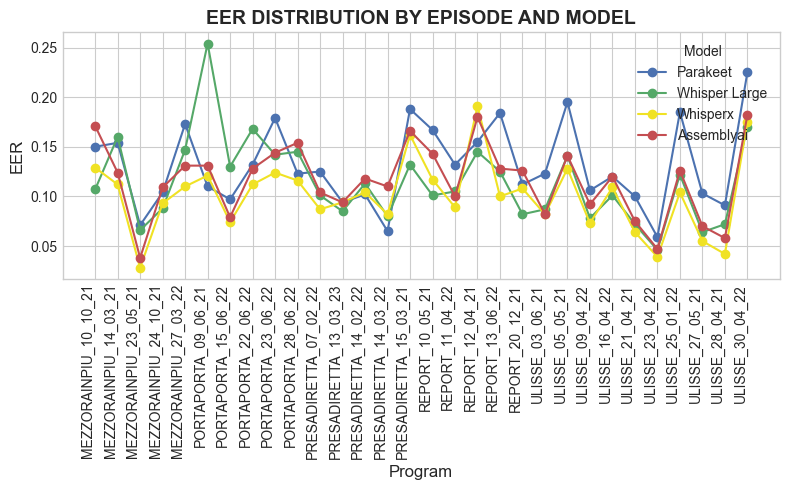

In [36]:
import plot

plot.plot_single_episode(stats_by_class_df, models=models, metric_name="EER")

### Per titolo di programma

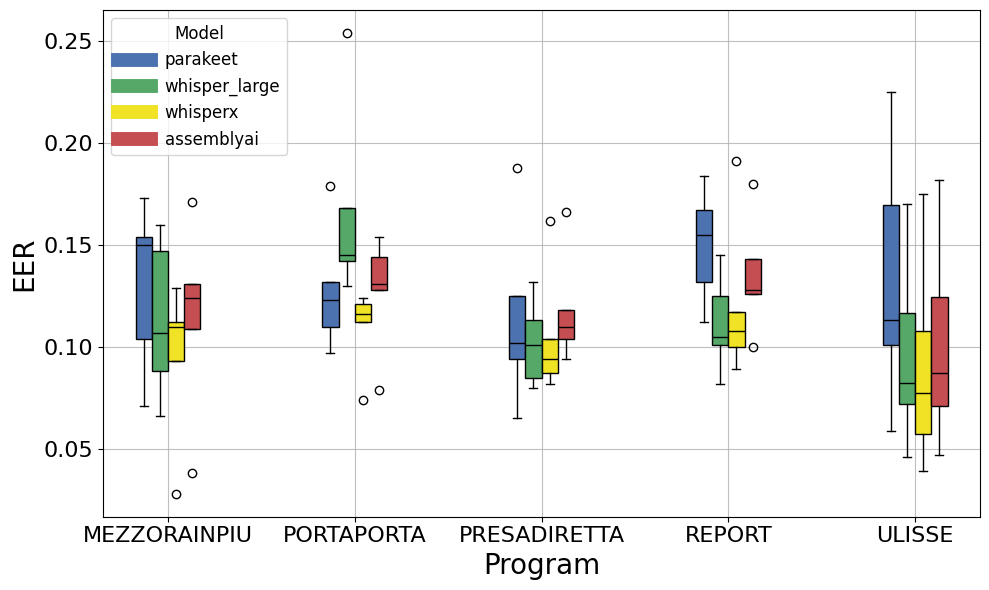

In [4]:
import plot

plot.plot_program(stats_by_class_df, metric_name="eer", models=models)

### Per tipologia

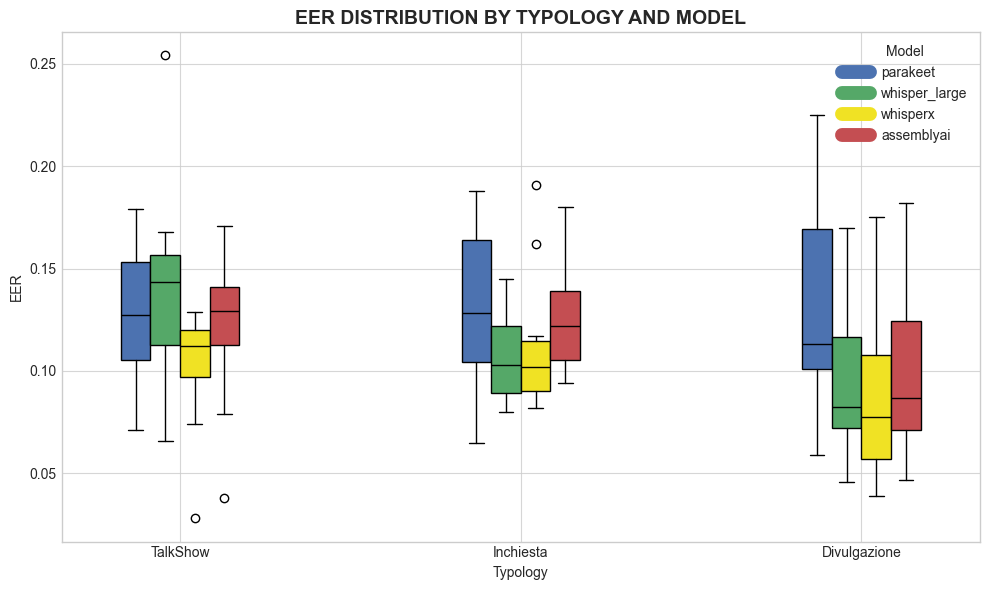

In [32]:
import plot

plot.plot_typology(stats_by_class_df, "eer", models)